In [ ]:
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
from scipy.io import loadmat
from scipy.stats import  pearsonr
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def get_max_freq_and_power(rates):
    freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
    max_freq_id = np.argmax(psd[:,:100],axis=1)
    max_freqs = freqs[max_freq_id]
    max_power = np.max(psd[:,:100],axis=1)
    return max_freqs, max_power,freqs,psd

nb_steps = 50000
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
# Load coefficients to estimte Decay with LR
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
C = 0.2*C/np.max(C)
triu_idx = np.triu_indices(C.shape[1],1)
burnout = 7
params = dmf.default_params(C=C)
params['N'] = C.shape[0]



G_max = 8
G_step = 0.25
G_range = np.arange(1,G_max,G_step)
LR_range = np.logspace(0, 4,100)


# Define the number of cores to use
NUM_CORES = 32
NREP = 8
max_freq_grid = np.zeros((NREP,len(G_range),len(LR_range)))
max_power_grid = np.zeros((NREP,len(G_range),len(LR_range)))
std_slow_grid = np.zeros((NREP,len(G_range),len(LR_range)))
corr_to_sc_grid = np.zeros((NREP,len(G_range),len(LR_range)))
homeostatic_fittness_grid = np.zeros((NREP,len(G_range),len(LR_range),params['N']))
rates_grid = np.zeros((NREP,len(G_range),len(LR_range),params['N']))
fic_t_grid = np.zeros((NREP,len(G_range),len(LR_range),params['N']))

params['with_plasticity'] = True
params['with_decay'] = True
params['return_bold'] = False
params['return_rate'] = True
params['return_fic'] = True


def grid_step(args):
    all_peak_autocorr = np.zeros((NREP))
    all_max_power = np.zeros((NREP))
    all_corr = np.zeros((NREP))
    all_homfit = np.zeros((NREP, params['N']))
    all_rates = np.zeros((NREP, params['N']))
    all_fic_t = np.zeros((NREP, params['N'] ))


    G_tuple, LR_tuple = args
    idx_LR,LR = LR_tuple[0],LR_tuple[1]
    idx_G,G = G_tuple[0],G_tuple[1]    
    DECAY = np.exp(a+np.log(LR)*b)
    OBJ_RATE = 3.44        
    params['lrj'] = LR
    params['G'] = G
    # Using heuristic linear rule 
    params['taoj'] = DECAY 
    params['obj_rate'] = OBJ_RATE
    #params['taoj'] = 210000
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    
    for idx in range(NREP):
        rates, _, _, fic_t = dmf.run(params, nb_steps)        
        rates = rates[:, np.ceil(burnout * 1000).astype(int):]    
        fic_t = fic_t[:, np.ceil(burnout * 1000).astype(int):]    
        rates_fc = np.corrcoef(rates)
        all_rates[idx,:] = np.mean(rates, axis=1)
        all_fic_t[idx,:] = np.mean(fic_t, axis=1)
        corr_to_sc = pearsonr(rates_fc[triu_idx[0],triu_idx[1]], C[triu_idx[0],triu_idx[1]])[0]
        all_corr[idx] = corr_to_sc
        max_freq,max_power,_,_ = get_max_freq_and_power(rates)        
        all_peak_autocorr[idx] = np.mean(max_freq)
        all_max_power[idx] = np.mean(max_power)
        homeostatic_fittness =  OBJ_RATE - np.mean(rates,axis=1)  
        all_homfit[idx, :] = np.mean(homeostatic_fittness)
    max_freq = all_peak_autocorr
    max_power = all_max_power
    corr_to_sc = all_corr
    homeostatic_fittness = all_homfit
    rates = all_rates
    fic_t = all_fic_t  

    return idx_G,idx_LR, max_freq,max_power,corr_to_sc,homeostatic_fittness,rates,fic_t


from multiprocessing import Pool,Manager


# Define the number of cores to use

# Create a list of argument tuples for the nested loop function
args_list = [((idx_G,G), (idx_LR,LR))
             for idx_G,G in enumerate(G_range)             
             for idx_LR,LR in enumerate(LR_range)]

manager = Manager()
results_list = manager.list()
# Create a pool of worker processes


with Pool(processes=NUM_CORES) as pool:
    # Map the nested loop function to the argument list across multiple processes
    results_list.extend(pool.map(grid_step, args_list))



for results in results_list:
    idx_G = results[0]    
    idx_LR = results[1]
    max_freq = results[2]
    max_power = results[3]    
    corr_to_sc = results[4]
    homeostatic_fittness = results[5]
    rates = results[6]
    fic_t = results[7]    
    max_freq_grid[:,idx_G,idx_LR] = max_freq
    max_power_grid[:,idx_G,idx_LR] = max_power        
    corr_to_sc_grid[:,idx_G,idx_LR] = corr_to_sc
    homeostatic_fittness_grid[:,idx_G,idx_LR] = homeostatic_fittness
    rates_grid[:,idx_G,idx_LR,:] = rates
    fic_t_grid[:,idx_G,idx_LR,:] = fic_t


    import os

# Assuming these arrays are already populated with data

arrays_to_save = {
    'max_freq_grid': max_freq_grid,
    'max_power_grid': max_power_grid,    
    'corr_to_sc_grid': corr_to_sc_grid,
    'homeostatic_fittness_grid': homeostatic_fittness_grid,
    'rates_grid': rates_grid,
    'fic_t_grid': fic_t_grid
}

results_folder = "./Results/slow_waves08"
# If the folder does not exist, create it
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    

# Save
for array_name, array_data in arrays_to_save.items():
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    np.save(file_name, array_data)


Debuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging bol

# test

In [16]:
args_list[1081]

((10, 3.5), (81, 284.8035868435802))

In [17]:
all_peak_autocorr = np.zeros((NREP))
all_max_power = np.zeros((NREP))
all_corr = np.zeros((NREP))
all_homfit = np.zeros((NREP, params['N']))
all_rates = np.zeros((NREP, params['N']))
all_fic_t = np.zeros((NREP, params['N'] ))


G_tuple, LR_tuple = args_list[1081]
idx_LR,LR = LR_tuple[0],LR_tuple[1]
idx_G,G = G_tuple[0],G_tuple[1]    
DECAY = np.exp(a+np.log(LR)*b)
OBJ_RATE = 3.44        
params['lrj'] = LR
params['G'] = G
# Using heuristic linear rule 
params['taoj'] = DECAY 
params['obj_rate'] = OBJ_RATE
#params['taoj'] = 210000
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1

for idx in range(NREP):
    rates, _, _, fic_t = dmf.run(params, nb_steps)        
    rates = rates[:, np.ceil(burnout * 1000).astype(int):]    
    fic_t = fic_t[:, np.ceil(burnout * 1000).astype(int):]    
    rates_fc = np.corrcoef(rates)
    all_rates[idx,:] = np.mean(rates, axis=1)
    all_fic_t[idx,:] = np.mean(fic_t, axis=1)
    corr_to_sc = pearsonr(rates_fc[triu_idx[0],triu_idx[1]], C[triu_idx[0],triu_idx[1]])[0]
    all_corr[idx] = corr_to_sc
    max_freq,max_power,_,_ = get_max_freq_and_power(rates)        
    all_peak_autocorr[idx] = np.mean(max_freq)
    all_max_power[idx] = np.mean(max_power)
    homeostatic_fittness =  OBJ_RATE - np.mean(rates,axis=1)  
    all_homfit[idx, :] = np.mean(homeostatic_fittness)
max_freq = all_peak_autocorr
max_power = all_max_power
corr_to_sc = all_corr
homeostatic_fittness = all_homfit
rates = all_rates
fic_t = all_fic_t  

Debuging boldDebuging bold

In [19]:
max_power

array([0.49919377, 0.49502708])

# test

In [74]:
import os
arrays_to_save = [
    'max_freq_grid',
    'max_power_grid',
    'corr_to_sc_grid',
    'homeostatic_fittness_grid',
    'rates_grid',
    'fic_t_grid'
]
results_folder = "./Results/slow_waves08"

results_08 = {}
for array_name in arrays_to_save:
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    results_08[array_name] = np.load(file_name)

In [75]:
results_folder = "./Results/slow_waves816"

results_816 = {}
for array_name in arrays_to_save:
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    results_816[array_name] = np.load(file_name)

In [111]:
max_freq_grid = np.concatenate([results_08['max_freq_grid'],results_816['max_freq_grid']], axis=1)
max_power_grid = np.concatenate([results_08['max_power_grid'],results_816['max_power_grid']], axis=1)
corr_to_sc_grid = np.concatenate([results_08['corr_to_sc_grid'],results_816['corr_to_sc_grid']], axis=1)
homeostatic_fittness_grid = np.concatenate([results_08['homeostatic_fittness_grid'],results_816['homeostatic_fittness_grid']], axis=1)
rates_grid = np.concatenate([results_08['rates_grid'],results_816['rates_grid']], axis=1)
fic_t_grid = np.concatenate([results_08['fic_t_grid'],results_816['fic_t_grid']], axis=1)


In [68]:
import os
arrays_to_save = [
    'peak_autocorrelation_grid',
    'peak_time_grid',
    
]
results_folder = "/home/ivan.mindlin/Desktop/DatosParaRuben/slow_waves/"

autocorr_grids = {}
for array_name in arrays_to_save:
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    autocorr_grids[array_name] = np.load(file_name)

In [71]:
autcorr_grid = autocorr_grids['peak_autocorrelation_grid'][:,:28,:]
time_grid = autocorr_grids['peak_time_grid'][:,:28,:]

### ploteo

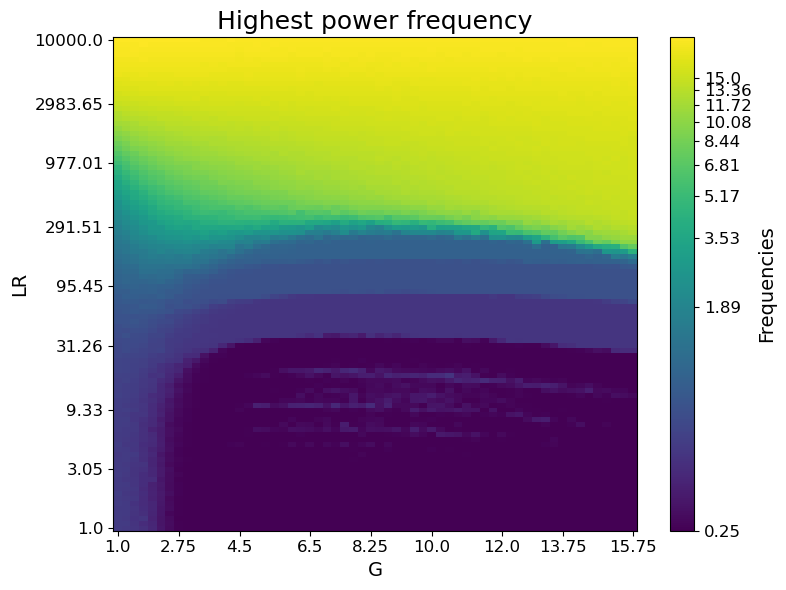

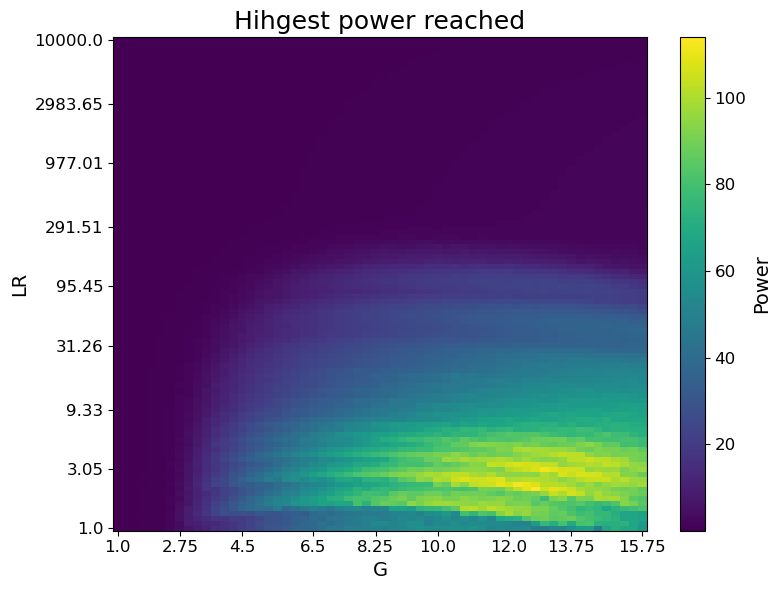

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
COLORBAR = 14

# Parameters
figname_base = 'FIG_5_'
figfold = '/home/ivan.mindlin/Desktop/DatosParaRuben/Figuras/panels/'
# Concatenating the data across different conditions
max_freq_grid = np.concatenate([results_08['max_freq_grid'], results_816['max_freq_grid']], axis=1)
max_power_grid = np.concatenate([results_08['max_power_grid'], results_816['max_power_grid']], axis=1)

# Compute mean values
mean_max_freq = max_freq_grid.mean(axis=0).T
mean_max_power = max_power_grid.mean(axis=0).T

# Define G and LR ranges
G_max = 16
G_step = 0.25
G_range = np.arange(1, G_max, G_step)
LR_range = np.logspace(0, 4, 100)

# Define tick indices and labels
lr_tick_indices = np.linspace(0, len(LR_range) - 1, 9, dtype=int)
lr_tick_labels = np.round(LR_range[lr_tick_indices], 2)
G_tick_indices = np.linspace(0, len(G_range) - 1, 9, dtype=int)
G_tick_labels = np.round(G_range[G_tick_indices], 2)

# FIG_2_A: Heatmap for max_freq_grid (Log Normalization)
fig_a, ax_a = plt.subplots(figsize=(8, 6))
im1 = ax_a.imshow(mean_max_freq, aspect='auto', cmap='viridis',
                  norm=LogNorm(vmin=mean_max_freq[mean_max_freq > 0].min(), vmax=mean_max_freq.max()),
                  origin='upper')

# Colorbar
cbar1 = fig_a.colorbar(im1, ax=ax_a)
v1 = np.linspace(mean_max_freq[mean_max_freq > 0].min(), 15, 10)
cbar1.set_ticks(v1)
cbar1.set_ticklabels(np.round(v1, 2))
cbar1.minorticks_off()
cbar1.set_label('Frequencies', fontsize=COLORBAR)
cbar1.ax.tick_params(labelsize=TICKS)



# Tick settings
ax_a.set_xticks(G_tick_indices)
ax_a.set_xticklabels(G_tick_labels, fontsize=TICKS)
ax_a.set_yticks(lr_tick_indices)
ax_a.set_yticklabels(lr_tick_labels, fontsize=TICKS)
ax_a.invert_yaxis()

# Labels and Title
ax_a.set_xlabel('G', fontsize=LABEL)
ax_a.set_ylabel('LR', fontsize=LABEL)
ax_a.set_title('Highest power frequency', fontsize=TITLE)

plt.tight_layout()
fig_a.savefig(figfold + figname_base + 'A.png', dpi=300)
fig_a.savefig(figfold + figname_base + 'A.svg', dpi=300)
plt.show()

# FIG_2_B: Heatmap for max_power_grid (Normal Display)
fig_b, ax_b = plt.subplots(figsize=(8, 6))
im2 = ax_b.imshow(mean_max_power, aspect='auto', cmap='viridis', origin='upper')

# Colorbar
cbar2 = fig_b.colorbar(im2, ax=ax_b)
cbar2.set_label('Power', fontsize=COLORBAR)
cbar2.ax.tick_params(labelsize=TICKS)

# Tick settings
ax_b.set_xticks(G_tick_indices)
ax_b.set_xticklabels(G_tick_labels, fontsize=TICKS)
ax_b.set_yticks(lr_tick_indices)
ax_b.set_yticklabels(lr_tick_labels, fontsize=TICKS)
ax_b.invert_yaxis()

# Labels and Title
ax_b.set_xlabel('G', fontsize=LABEL)
ax_b.set_ylabel('LR', fontsize=LABEL)
ax_b.set_title('Hihgest power reached', fontsize=TITLE)

plt.tight_layout()
fig_b.savefig(figfold + figname_base + 'B.png', dpi=300)
fig_b.savefig(figfold + figname_base + 'B.svg', dpi=300)
plt.show()


In [131]:
(std_max_freq==0).sum()

1757

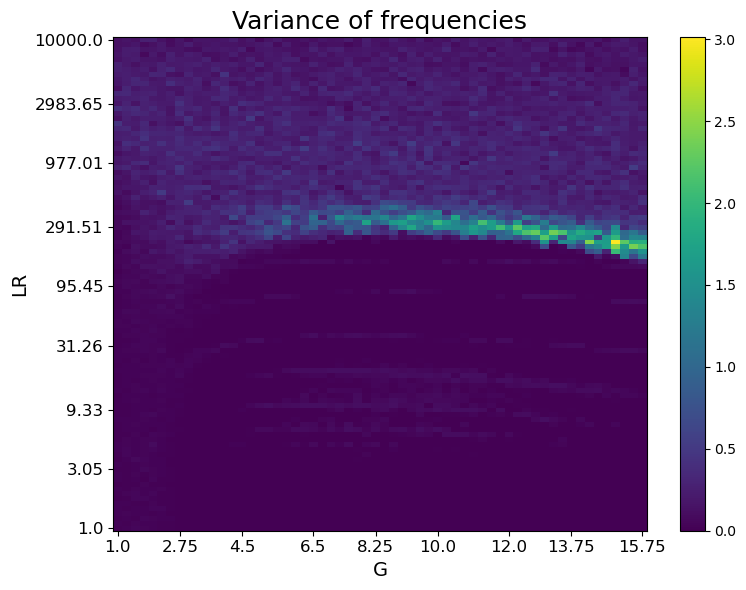

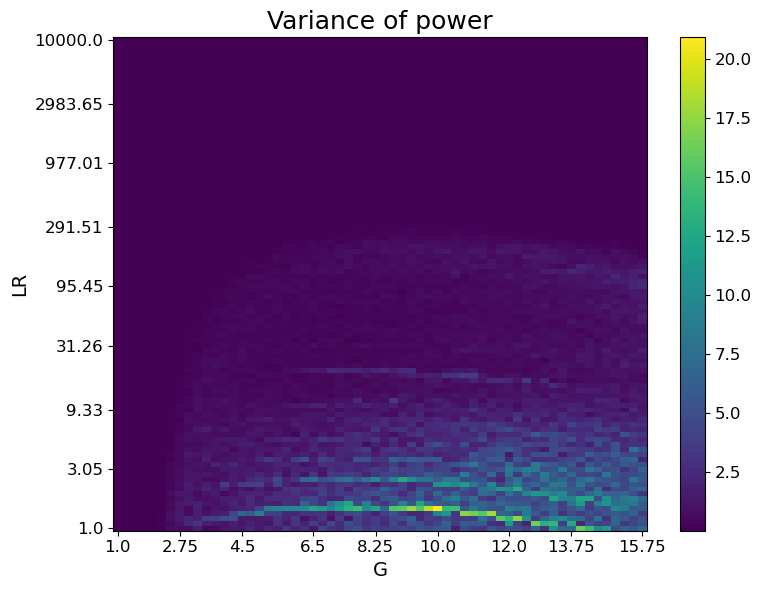

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
COLORBAR = 14

# Parameters
figname_base = 'FIG_5_'
figfold = '/home/ivan.mindlin/Desktop/DatosParaRuben/Figuras/panels/'
# Concatenating the data across different conditions
max_freq_grid = np.concatenate([results_08['max_freq_grid'], results_816['max_freq_grid']], axis=1)
max_power_grid = np.concatenate([results_08['max_power_grid'], results_816['max_power_grid']], axis=1)

# Compute std values
std_max_freq = max_freq_grid.std(axis=0).T
std_max_power = max_power_grid.std(axis=0).T

# Define G and LR ranges
G_max = 16
G_step = 0.25
G_range = np.arange(1, G_max, G_step)
LR_range = np.logspace(0, 4, 100)

# Define tick indices and labels
lr_tick_indices = np.linspace(0, len(LR_range) - 1, 9, dtype=int)
lr_tick_labels = np.round(LR_range[lr_tick_indices], 2)
G_tick_indices = np.linspace(0, len(G_range) - 1, 9, dtype=int)
G_tick_labels = np.round(G_range[G_tick_indices], 2)

# FIG_2_A: Heatmap for max_freq_grid (Log Normalization)
fig_a, ax_a = plt.subplots(figsize=(8, 6))
im1 = ax_a.imshow(std_max_freq, aspect='auto', cmap='viridis', origin='upper')

# Colorbar
cbar1 = fig_a.colorbar(im1, ax=ax_a)


# Tick settings
ax_a.set_xticks(G_tick_indices)
ax_a.set_xticklabels(G_tick_labels, fontsize=TICKS)
ax_a.set_yticks(lr_tick_indices)
ax_a.set_yticklabels(lr_tick_labels, fontsize=TICKS)
ax_a.invert_yaxis()

# Labels and Title
ax_a.set_xlabel('G', fontsize=LABEL)
ax_a.set_ylabel('LR', fontsize=LABEL)
ax_a.set_title('Variance of frequencies', fontsize=TITLE)

plt.tight_layout()
fig_a.savefig(figfold + figname_base + 'C.png', dpi=300)
fig_a.savefig(figfold + figname_base + 'C.svg', dpi=300)
plt.show()

# FIG_2_B: Heatmap for max_power_grid (Normal Display)
fig_b, ax_b = plt.subplots(figsize=(8, 6))
im2 = ax_b.imshow(std_max_power, aspect='auto', cmap='viridis', origin='upper')

# Colorbar
cbar2 = fig_b.colorbar(im2, ax=ax_b)
#cbar2.set_label('Power', fontsize=COLORBAR)
cbar2.ax.tick_params(labelsize=TICKS)

# Tick settings
ax_b.set_xticks(G_tick_indices)
ax_b.set_xticklabels(G_tick_labels, fontsize=TICKS)
ax_b.set_yticks(lr_tick_indices)
ax_b.set_yticklabels(lr_tick_labels, fontsize=TICKS)
ax_b.invert_yaxis()

# Labels and Title
ax_b.set_xlabel('G', fontsize=LABEL)
ax_b.set_ylabel('LR', fontsize=LABEL)
ax_b.set_title('Variance of power', fontsize=TITLE)

plt.tight_layout()
fig_b.savefig(figfold + figname_base + 'D.png', dpi=300)
fig_b.savefig(figfold + figname_base + 'D.svg', dpi=300)
plt.show()


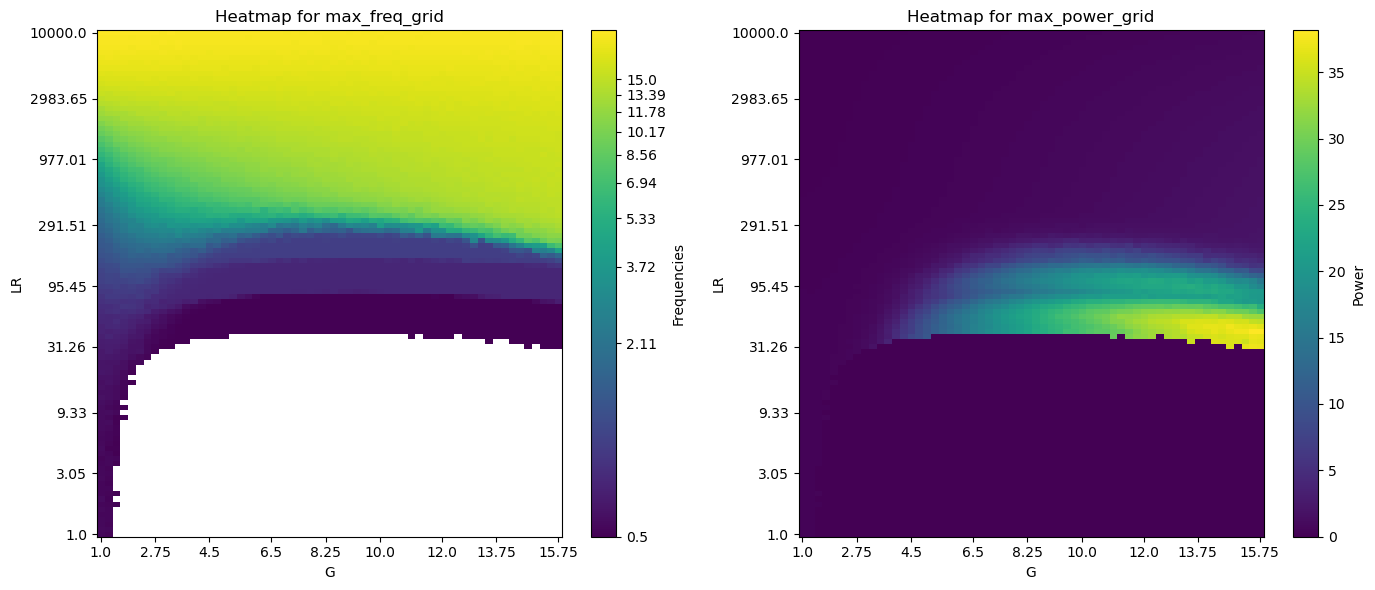

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Example definitions (replace these with your actual arrays)
# Ensure that your frequency data has no zero or negative values before applying LogNorm.
# If necessary, add a small constant to avoid issues.
mean_max_freq = max_freq_grid.mean(axis=0).T



# Extract indices where the mean max frequency is below 0.5

indices = np.argwhere(mean_max_freq < 0.5)
max_power_grid[:, indices[:, 1], indices[:, 0]] = 0
mean_max_freq[indices[:, 0], indices[:, 1]] = 0




G_max = 16
G_step = 0.25
G_range = np.arange(1,G_max,G_step)
LR_range = np.logspace(0, 4,100)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for max_freq_grid using logarithmic normalization
im1 = axs[0].imshow(mean_max_freq, aspect='auto', cmap='viridis',
                     norm=LogNorm(vmin=mean_max_freq[mean_max_freq > 0].min(), vmax=mean_max_freq.max()),
                     origin='upper')
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label('Frequencies')

v1 = np.linspace(mean_max_freq[mean_max_freq > 0].min(), 15, 10)
cbar1.set_ticks(v1)
cbar1.set_ticklabels(np.round(v1, 2))
cbar1.minorticks_off()

axs[0].set_xlabel('G')
axs[0].set_ylabel('LR')
axs[0].set_title('Heatmap for max_freq_grid')

# Setting a subset of tick labels for LR (assuming lr_tick_indices and lr_tick_labels as defined earlier)

lr_tick_indices = np.linspace(0, len(LR_range)-1, 9, dtype=int)
lr_tick_labels = np.round(LR_range[lr_tick_indices], 2)

G_tick_indices = np.linspace(0, len(G_range)-1, 9, dtype=int)
G_tick_labels = np.round(G_range[G_tick_indices], 2)
axs[0].set_xticks(G_tick_indices)
axs[0].set_xticklabels(G_tick_labels)
axs[0].set_yticks(lr_tick_indices)
axs[0].set_yticklabels(lr_tick_labels)
axs[0].invert_yaxis()

# Plot for max_power_grid (normal display)
mean_max_power = max_power_grid.mean(axis=0).T
im2 = axs[1].imshow(mean_max_power, aspect='auto', cmap='viridis', origin='upper')
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label('Power')
axs[1].set_xlabel('G')
axs[1].set_ylabel('LR')
axs[1].set_title('Heatmap for max_power_grid')

# Apply the same tick settings for the second subplot if needed
axs[1].set_xticks(G_tick_indices)
axs[1].set_xticklabels(G_tick_labels)
axs[1].set_yticks(lr_tick_indices)
axs[1].set_yticklabels(lr_tick_labels)
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()


TypeError: Colorbar.set_ticklabels() missing 1 required positional argument: 'ticklabels'

In [89]:
cbar1.minorticks_on()

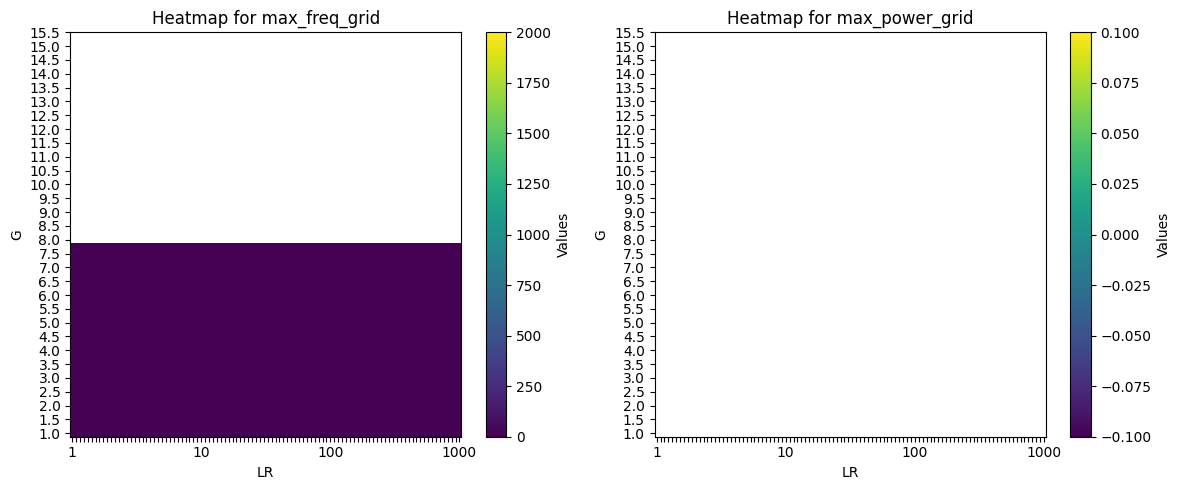

In [ ]:

# Create subplots
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

G_max = 16
G_step = 0.25
G_range = np.arange(1,G_max,G_step)
LR_range = np.logspace(0, 3,100)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Heatmap for max_freq_grid
im1 = axes[0].imshow(np.mean(max_freq_grid,axis=0), cmap='viridis', origin='lower', aspect='auto', vmax=2000)
axes[0].set_title('Heatmap for max_freq_grid')
axes[0].set_xlabel('LR')
axes[0].set_ylabel('G')
# Set logarithmic tick labels for LR
log_labels = ['' for _ in range(len(LR_range))]
log_labels[0] = 1
log_labels[33] = 10
log_labels[66] = 100
log_labels[99] = 1000
axes[0].set_xticks(range(len(LR_range)))
axes[0].set_xticklabels(log_labels)
axes[0].set_yticks(range(0,60,2))
axes[0].set_yticklabels(G_range[range(0,60,2)])
plt.colorbar(im1, ax=axes[0], label='Values')
# Heatmap for max_power_grid
im2 = axes[1].imshow(np.mean(max_power_grid,axis=0), cmap='viridis', origin='lower', aspect='auto')
axes[1].set_title('Heatmap for max_power_grid')
axes[1].set_xlabel('LR')
axes[1].set_ylabel('G')
axes[1].set_xticks(range(len(LR_range)))
axes[1].set_xticklabels(log_labels)
axes[1].set_yticks(range(0,60,2))
axes[1].set_yticklabels(G_range[range(0,60,2)])
plt.colorbar(im2, ax=axes[1], label='Values')
plt.tight_layout()
plt.show()